# Učitavanje, filtriranje i vizuelizacija podataka o polenu

## Učitavanje biblioteka

In [1]:
# Standardne biblioteke
import warnings
import re
from datetime import date

# Obrada podataka
import numpy as np
import pandas as pd

# Statističke i matematičke funkcija
from scipy.stats import pearsonr

# Vizualizacija
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar
from adjustText import adjust_text

# Geoprostorne biblioteke
import geopandas as gpd
from geopy.distance import geodesic
import contextily as ctx

# Ostale korisne biblioteke
from transliterate import translit
from rapidfuzz import process, fuzz

# Lokalni notebook za grafove
%run 00_graphs.ipynb

# Isključivanje upozorenja
warnings.filterwarnings('ignore')

c:\Users\lukam\anaconda3\envs\op_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Učitavanje podaka

### Koncentracija

In [ ]:
# Učitavanje podataka o koncentracijama polena
concentrations = pd.read_csv('data\\pollen-concentration.csv', parse_dates=['pollen__date'])

# Alternativa: direktno učitavanje sa data.gov.rs
# concentrations = pd.read_csv(
#     'https://data.gov.rs/sr/datasets/r/812158f7-2809-4f1f-b6ff-751f3b1b0b2f',
#     parse_dates=['pollen__date']
# )

# Preimenovanje kolona u jednostavnije nazive
concentrations.columns = ['date', 'location', 'allergen', 'value']

# Prevodjenje imena lokacija i alergena sa ćirilice na latinicu
concentrations['location'] = concentrations['location'].apply(
    lambda x: translit(x, 'sr', reversed=True) if isinstance(x, str) else x
)
concentrations['allergen'] = concentrations['allergen'].apply(
    lambda x: translit(x, 'sr', reversed=True) if isinstance(x, str) else x
)

concentrations.head(10)

,date,location,allergen,value
0,2025-05-26,BEOGRAD - NOVI BEOGRAD,JAVOR,2
1,2025-05-26,BEOGRAD - NOVI BEOGRAD,KONOPLjE,3
2,2025-05-26,BEOGRAD - NOVI BEOGRAD,KOPRIVA,10
3,2025-05-26,BEOGRAD - NOVI BEOGRAD,LIPA,16
4,2025-05-26,BEOGRAD - NOVI BEOGRAD,ORAH,1
5,2025-05-26,BEOGRAD - NOVI BEOGRAD,TRAVE,16
6,2025-05-26,BEOGRAD - NOVI BEOGRAD,ČETINARI,30
7,2025-05-26,ZRENjANIN,BOKVICA,1
8,2025-05-26,ZRENjANIN,VRBA,1
9,2025-05-26,ZRENjANIN,JASEN,1


### Lokacija

In [ ]:
# Učitavanje podataka o lokacijama iz Excel fajla
locations = pd.read_excel('data\\polen-lokacije.xlsx')

# Alternativa: direktno učitavanje sa data.gov.rs (zakomentarisano za sada)
# locations = pd.read_excel(
#     'https://data.gov.rs/sr/datasets/r/2f9e795d-911b-4664-878f-cb58a02de30e'
# )

# Brisanje nepotrebnih kolona
locations.drop(columns=['Скраћено име', 'Недеља почиње у'], inplace=True)

# Preimenovanje kolona u jednostavnije nazive
locations.columns = ['location', 'latitude', 'longitude']

# Prevođenje imena lokacija sa ćirilice na latinicu
locations['location'] = locations['location'].apply(
    lambda x: translit(x, 'sr', reversed=True) if isinstance(x, str) else x
)

locations

,location,latitude,longitude
0,BEOGRAD - ZELENO BRDO,44.786241,20.521657
1,BEOGRAD - NOVI BEOGRAD,44.823174,20.412914
2,BEOGRAD - ČUKARICA,44.766750,20.417120
3,BEČEJ,45.613056,20.052766
4,VALjEVO,44.270884,19.887231
5,VRANjE,42.551460,21.902314
6,VRBAS,45.572060,19.640300
7,VRŠAC,45.116670,21.303610
8,ZAJEČAR,43.906308,22.278354
9,ZLATIBOR,43.721861,19.708328


#### Prikaz svih lokacija na kojima se vrši merenje

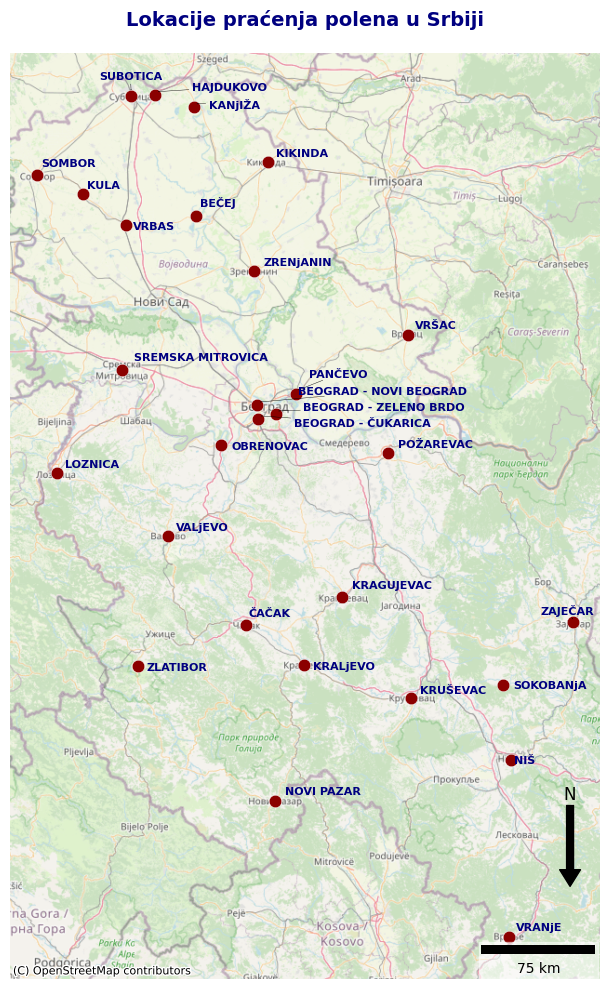

In [7]:
plot_monitoring_locations(locations)

### Alergeni

In [ ]:
# Učitavanje podataka o alergenima
allergens = pd.read_excel('data\\polen-alergeni.xlsx')

# Alternativa: direktno sa data.gov.rs
# allergens = pd.read_excel('https://data.gov.rs/sr/datasets/r/2f9e795d-911b-4664-878f-cb58a02de30e')

# Brisanje nepotrebnih kolona
allergens.drop(columns=['Biljna vrsta', 'Narodni naziv', 'Engleski naziv', 'slika / link'], inplace=True)

# Preimenovanje kolona
allergens.columns = ['allergen', 'Tip alergena', 'Donja vrednost', 'Gornja vrednost', 'Period emitovanja polena', 'Alergenost']

# Transliteracija i formatiranje
allergens['allergen'] = allergens['allergen'].apply(lambda x: translit(x, 'sr', reversed=True) if isinstance(x, str) else x)
allergens['Period emitovanja polena'] = allergens['Period emitovanja polena'].apply(lambda x: translit(x, 'sr', reversed=True) if isinstance(x, str) else x)
allergens['Period emitovanja polena'] = allergens['Period emitovanja polena'].str.lower()

allergens

,allergen,Tip alergena,Donja vrednost,Gornja vrednost,Period emitovanja polena,Alergenost
0,AMBROZIJA,КОРОВИ (АМБРОЗИЈА),30,100,sredina jula- septembar,Веома јака
1,BOKVICA,КОРОВИ,60,100,maj- septembar,Слаба до умерена
2,ČETINARI,ДРВЕЋЕ,60,100,mart- kraj maja,Слаба
3,BREZA,ДРВЕЋЕ,60,100,mart- početak juna,Веома јака
4,BREST,ДРВЕЋЕ,60,100,mart-april,Умерена
5,BUKVA,ДРВЕЋЕ,60,100,mart- maj,Слаба до умерена
6,VRBA,ДРВЕЋЕ,60,100,mart- kraj maja,Слаба
7,GRAB,ДРВЕЋЕ,60,100,mart-maj,Слаба до умерена
8,DUD,ДРВЕЋЕ,60,100,april- jun,Слаба до умерена
9,JAVOR,ДРВЕЋЕ,60,100,mart- kraj maja,Слаба до умерена


#### Određivanje početka i kraja sezone alergena

In [9]:
# Mapiranje meseci i pozicija
meseci = {
    'januar': 1, 'februar': 2, 'mart': 3, 'april': 4,
    'maj': 5, 'jun': 6, 'jul': 7, 'avgust': 8,
    'septembar': 9, 'oktobar': 10, 'novembar': 11, 'decembar': 12
}

pozicije = {
    'početak': 1,
    'sredina': 15,
    'kraj': 28
}

# Funkcija za parsiranje perioda emitovanja polena
def parse_period(tekst):
    tekst = tekst.lower().strip()
    pattern = r'(?:(početak|sredina|kraj)\s)?([a-zšđčćž]+)-?\s?(?:(početak|sredina|kraj)\s)?([a-zšđčćž]+)'
    match = re.search(pattern, tekst)
    
    if not match:
        return None, None

    start_part, start_month, end_part, end_month = match.groups()

    start_day = pozicije.get(start_part, 5)
    start_month_num = meseci.get(start_month.rstrip('a'))

    if end_part == 'početak':
        end_day = 10
        end_month_num = meseci.get(end_month.rstrip('a'))
    elif end_part == 'kraj':
        end_day = 1
        end_month_num = meseci.get(end_month.rstrip('a')) + 1
    else:
        end_day = 25
        end_month_num = meseci.get(end_month.rstrip('a'))
    
    if not start_month_num or not end_month_num:
        return None, None

    start_date = (date(2024, start_month_num, start_day) - pd.Timedelta(days=6)).strftime('%m-%d')
    end_date = (date(2024, end_month_num, end_day) + pd.Timedelta(days=6)).strftime('%m-%d')
    
    return start_date, end_date

# Dodavanje start_date i end_date kolona
allergens[['start_date', 'end_date']] = allergens['Period emitovanja polena'].apply(
    lambda x: pd.Series(parse_period(x))
)


### Spajanje tabela

In [10]:
# Jedinstveni alergeni iz oba skupa
unique_conc = concentrations['allergen'].unique()
unique_alrg = allergens['allergen'].unique()

# Prag za fuzzy matching
threshold = 75

# Mapiranje najboljih podudaranja
mapping = {}
for a1 in unique_conc:
    best_match = process.extractOne(a1, unique_alrg, scorer=fuzz.token_sort_ratio)
    if best_match and best_match[1] >= threshold:
        mapping[a1] = best_match[0]

# Nova kolona sa mapiranim alergenima
concentrations['allergen_matched'] = concentrations['allergen'].map(mapping)

# Spajanje sa alergenima
df = concentrations.merge(
    allergens,
    left_on='allergen_matched',
    right_on='allergen',
    how='inner',
    suffixes=('_conc', '')
)

# Brisanje nepotrebnih kolona
df.drop(columns=[
    'allergen_conc', 'allergen_matched', 'Tip alergena',
    'Donja vrednost', 'Gornja vrednost',
    'Period emitovanja polena', 'Alergenost'
], inplace=True, errors='ignore')


### Prikaz odabranih alergena i gradova

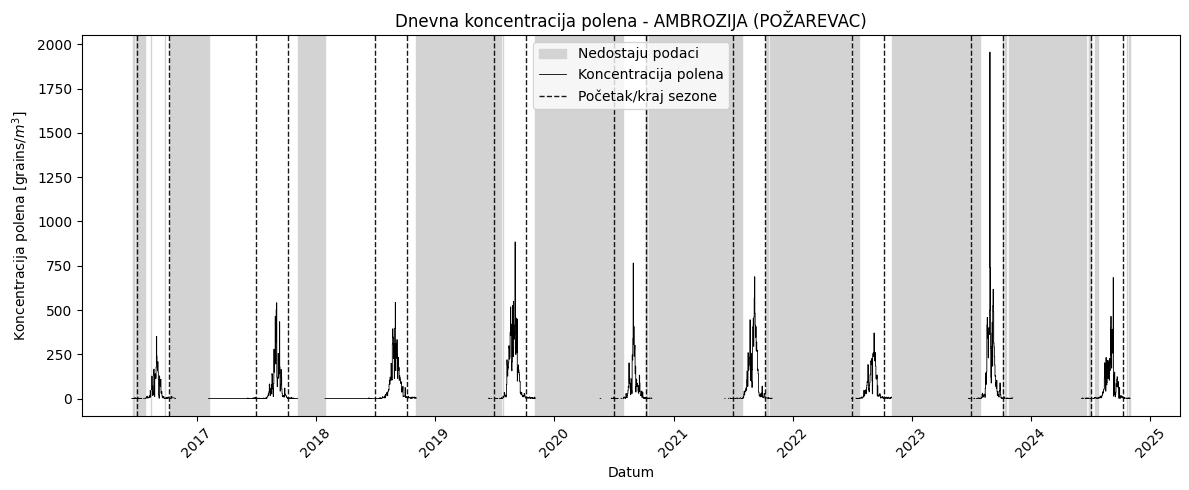

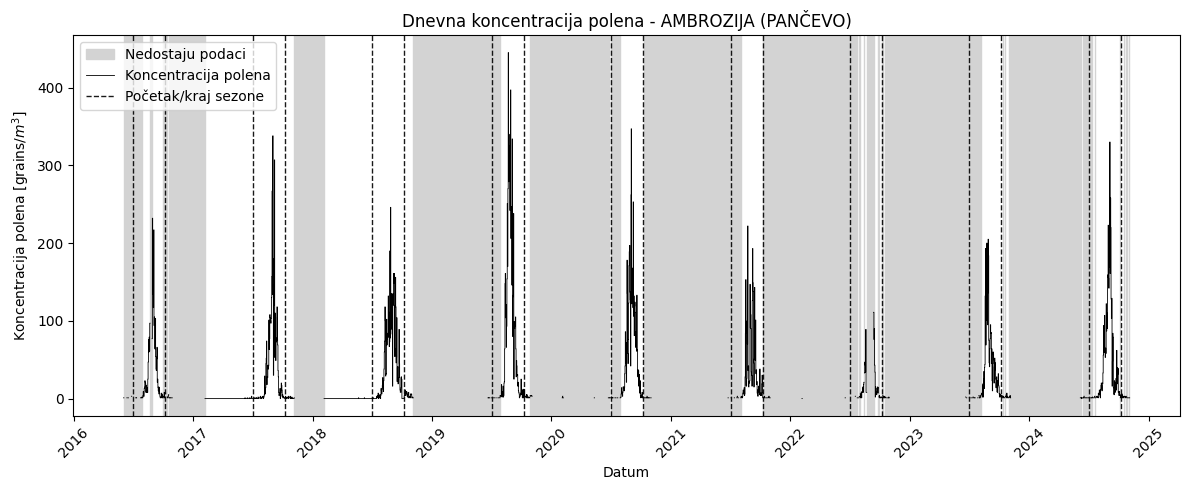

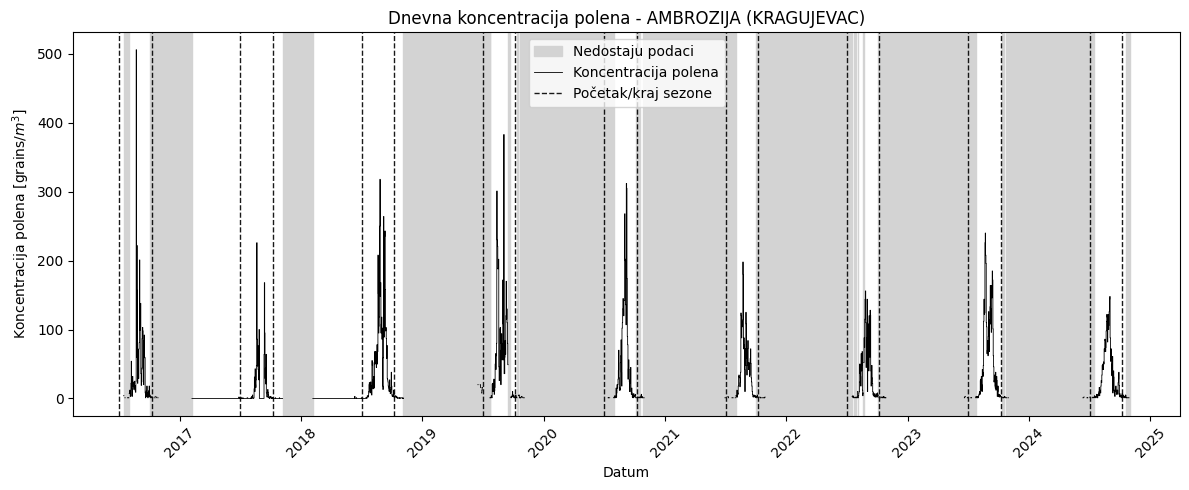

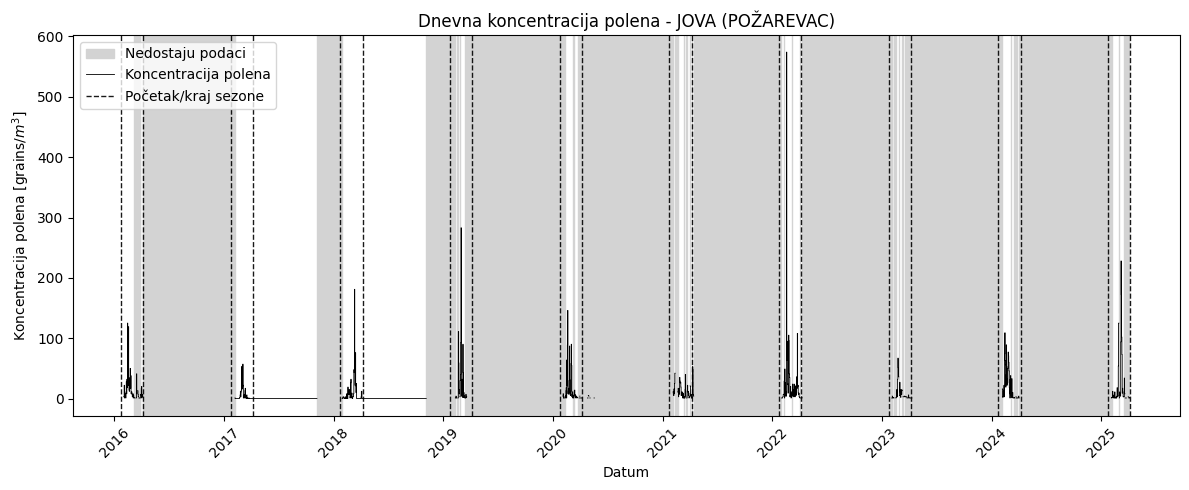

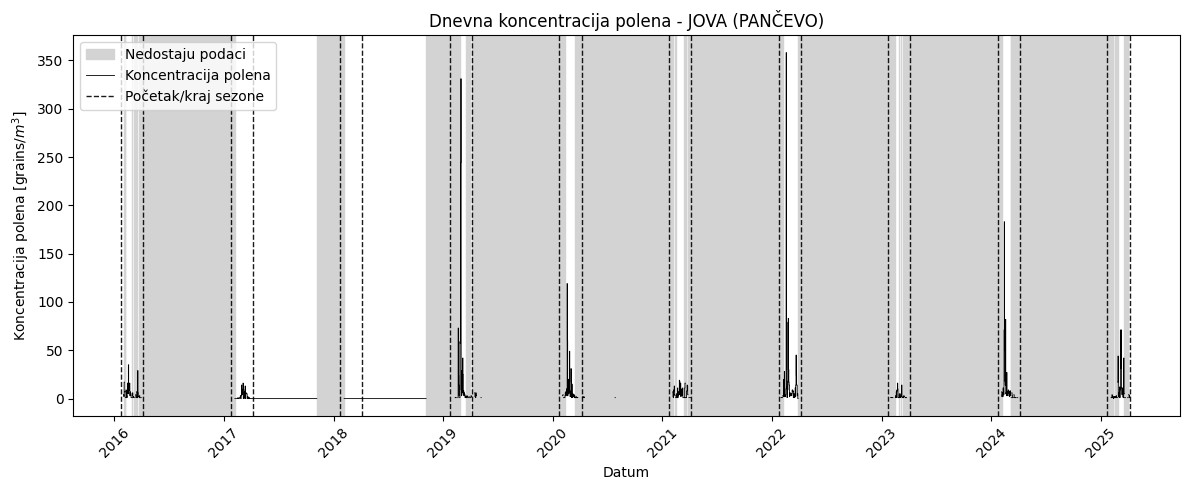

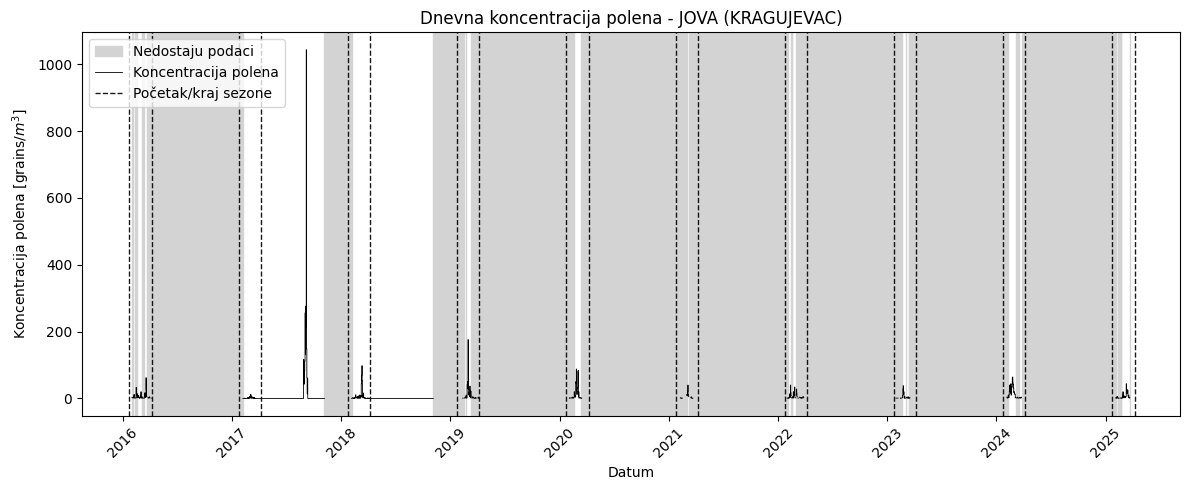

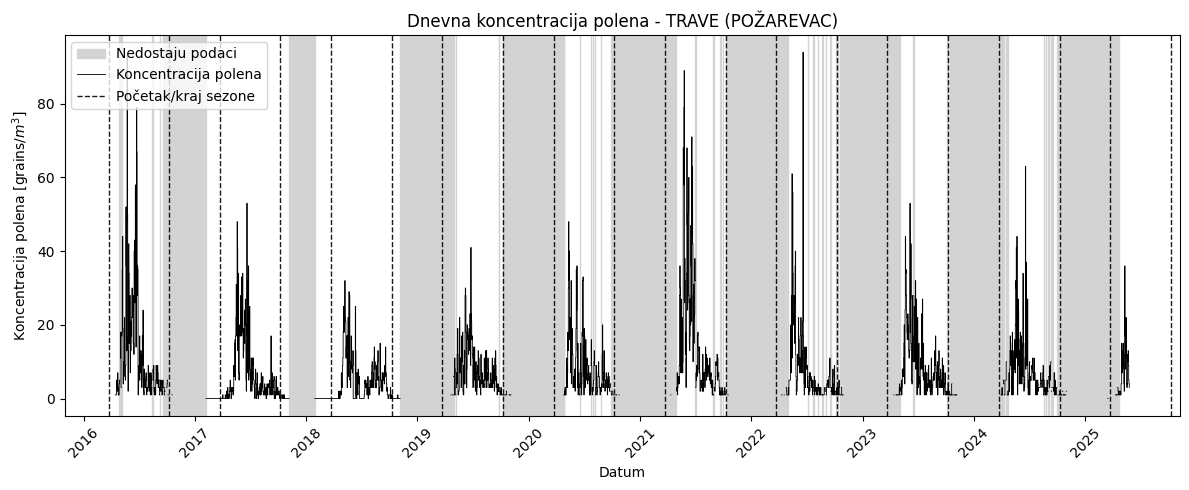

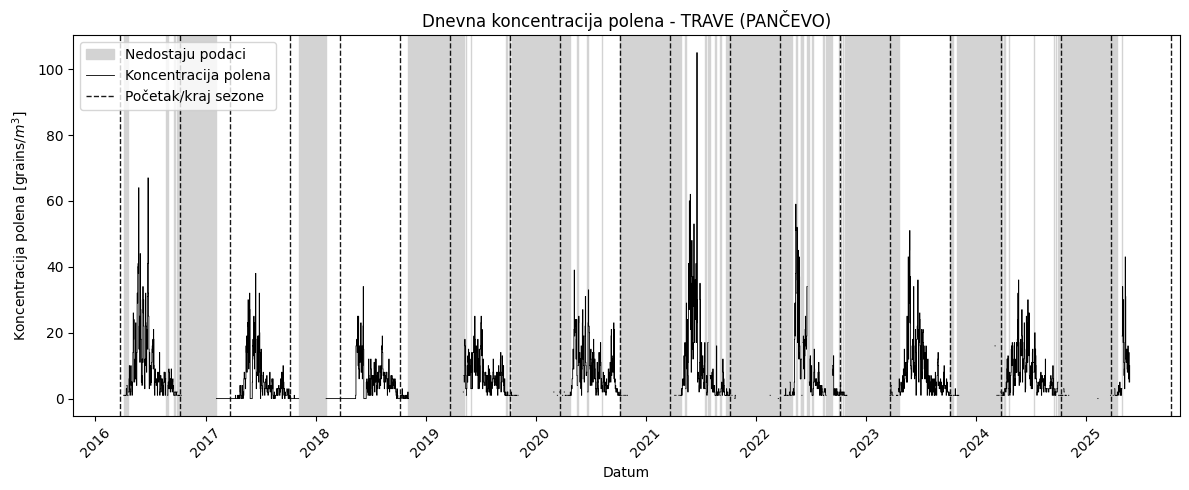

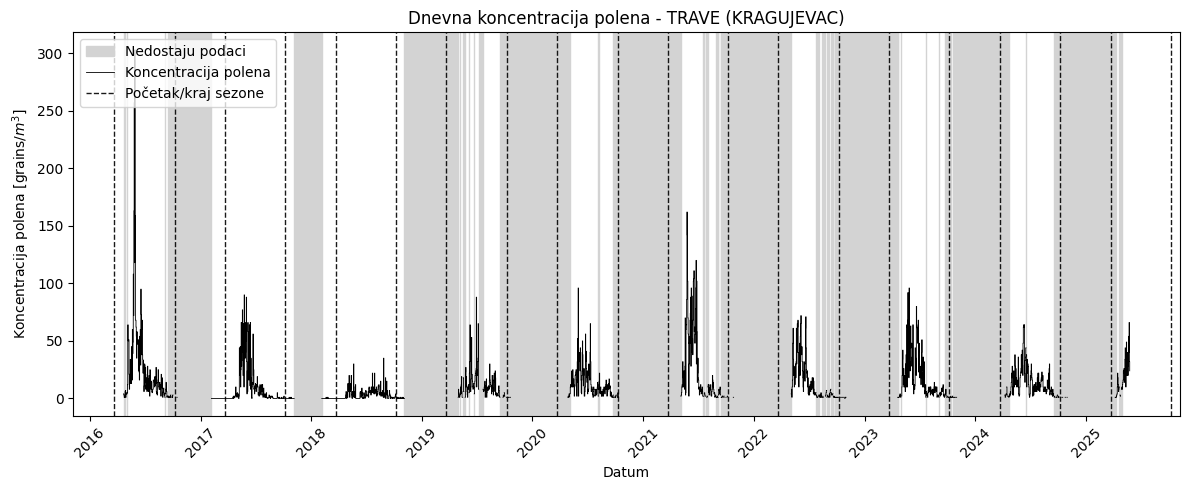

In [12]:
allergen_types = ['AMBROZIJA', 'JOVA', 'TRAVE']
cities = ['POŽAREVAC', 'PANČEVO', 'KRAGUJEVAC']

# Petlja kroz sve gradove i alergene
for allergen in allergen_types:
    for grad in cities:
        subset = df[(df['location'] == grad) & (df['allergen'] == allergen)]
        if not subset.empty:
            plot_daily_concentration(subset, save=True)


## Filtriranje podataka

### Filtriranje samo sezonskih perioda i izbacivanje parava alergena i lokacije koja imaju nedovoljno merenja

Broj jedinstvenih (location, allergen) parova na početku: 732
Broj parova izbačenih iz analize: 208
Broj parova koji su ostali u analizi: 524

Primeri izbačenih parova:


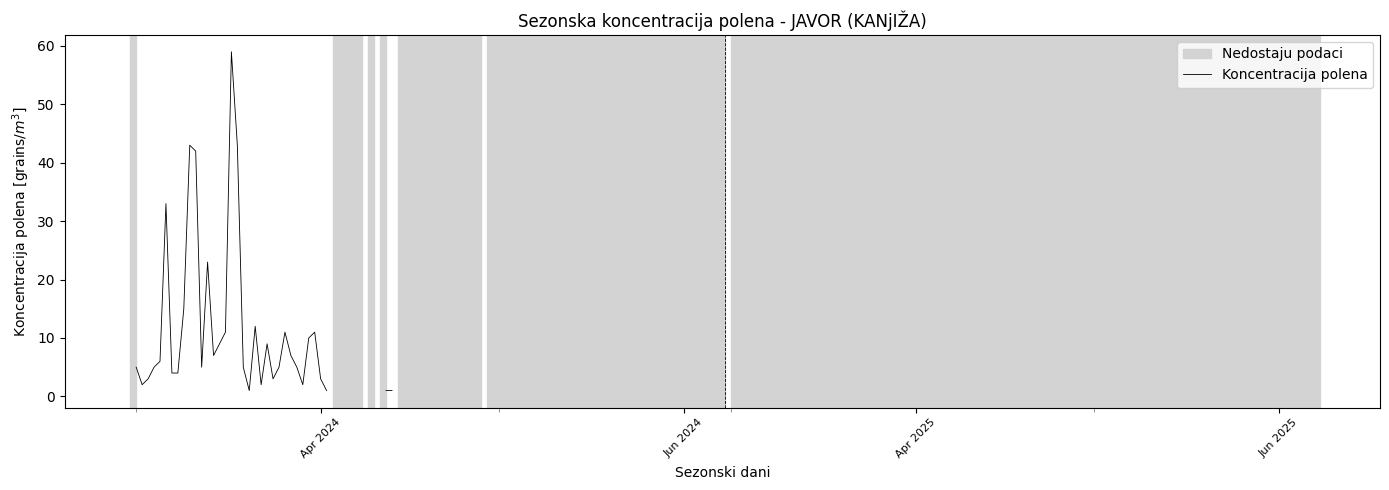

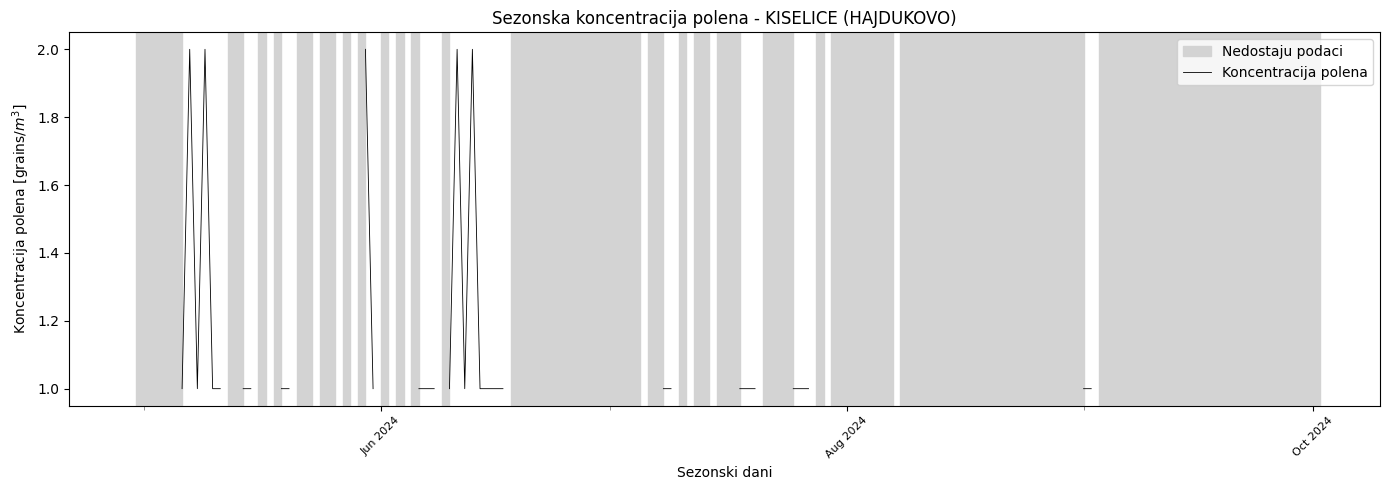

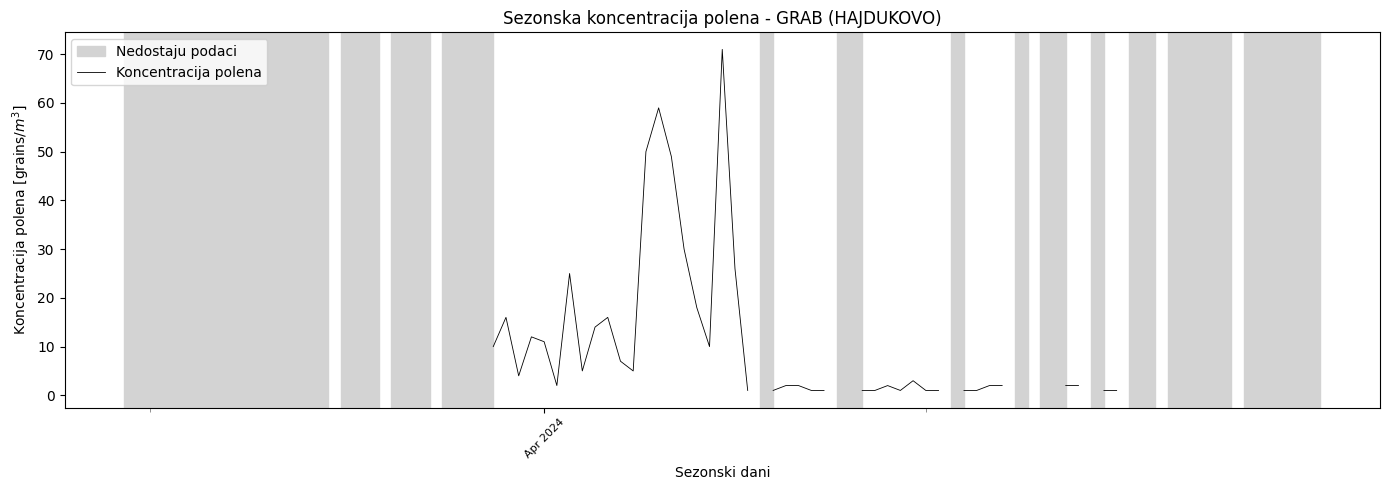

In [13]:
# Izdvajanje meseca i dana
df['month_day'] = df['date'].dt.strftime('%m-%d')
df['year'] = df['date'].dt.year

# Filtriranje u sezonskom periodu
filtered_df = df[(df['month_day'] >= df['start_date']) & (df['month_day'] <= df['end_date'])].copy()

# Trajanje sezone
dates_dummy = pd.to_datetime('2020-' + filtered_df['start_date']) 
dates_dummy_end = pd.to_datetime('2020-' + filtered_df['end_date'])
filtered_df['season_length'] = (dates_dummy_end - dates_dummy).dt.days + 1

# Broj dana sa podacima po (location, allergen, year)
filtered_df['days_with_data'] = (
    filtered_df.groupby(['location', 'allergen', 'year'])['value']
    .transform('count')
)

# Prag za validne godine
filtered_df['threshold'] = filtered_df['season_length'] * 0.3
filtered_df['valid_year'] = filtered_df['days_with_data'] > filtered_df['threshold']

# Broj validnih godina po (location, allergen)
valid_years_counts = (
    filtered_df[filtered_df['valid_year']]
    .groupby(['location', 'allergen'])['year']
    .nunique()
)

# Zadrži klase sa ≥7 validnih godina
keep_classes = valid_years_counts[valid_years_counts >= 7].reset_index()

# Finalni filtrirani DataFrame
filtered_df = filtered_df.merge(keep_classes, on=['location', 'allergen'], how='inner')

# Unikatni parovi na početku i na kraju
initial_pairs = df[['location', 'allergen']].drop_duplicates()
final_pairs = filtered_df[['location', 'allergen']].drop_duplicates()

# Parovi koji su izbačeni
removed_pairs = initial_pairs.merge(final_pairs, on=['location', 'allergen'], how='left', indicator=True)
removed_pairs = removed_pairs[removed_pairs['_merge'] == 'left_only'][['location', 'allergen']]

# Broj parova
print(f"Broj jedinstvenih (location, allergen) parova na početku: {initial_pairs.shape[0]}")
print(f"Broj parova izbačenih iz analize: {removed_pairs.shape[0]}")
print(f"Broj parova koji su ostali u analizi: {final_pairs.shape[0]}")

# Prikaz nekoliko izbačenih parova
print("\nPrimeri izbačenih parova:")

# Nasumično izaberi 3 izbačena para
sample_removed = removed_pairs.sample(3, random_state=13)
for _, row in sample_removed.iterrows():
    subset = df[(df['location'] == row['location']) & (df['allergen'] == row['allergen'])]
    
    if not subset.empty:
        plot_seasonal_concentration(subset, save=True)


## Učitavanje meteoroloških podataka

In [14]:
meteo_df = pd.read_csv('meteo\meteo_df.csv', parse_dates = ['date'])
meteo = filtered_df.merge(meteo_df, on=['date', 'location'], how='left')
meteo_df.head(10)

,date,temperature,precipitation,humidity,wind,wind_direction,location
0,2016-01-01,-6.740082,0.000000,73.195690,2.404302,2.463254,BEOGRAD - NOVI BEOGRAD
1,2016-01-02,-3.026703,0.008856,90.787380,0.528750,0.579046,BEOGRAD - NOVI BEOGRAD
2,2016-01-03,-3.762787,0.362447,82.964390,5.517377,2.932264,BEOGRAD - NOVI BEOGRAD
3,2016-01-04,-11.008392,0.004127,85.549300,4.424964,2.590824,BEOGRAD - NOVI BEOGRAD
4,2016-01-05,-4.662933,0.513194,99.236534,0.731181,-1.668313,BEOGRAD - NOVI BEOGRAD
5,2016-01-06,-1.265228,0.000923,92.814290,2.254578,2.995079,BEOGRAD - NOVI BEOGRAD
6,2016-01-07,1.355865,0.042404,97.738280,2.284577,-0.309320,BEOGRAD - NOVI BEOGRAD
7,2016-01-08,-2.441742,0.000000,98.664840,1.512377,1.561145,BEOGRAD - NOVI BEOGRAD
8,2016-01-09,3.247223,0.000000,82.186580,3.117998,2.343104,BEOGRAD - NOVI BEOGRAD
9,2016-01-10,6.920075,0.000000,82.969100,3.091699,1.892782,BEOGRAD - NOVI BEOGRAD


### Zavisnost koncetracija polena od meteoroloških parametara

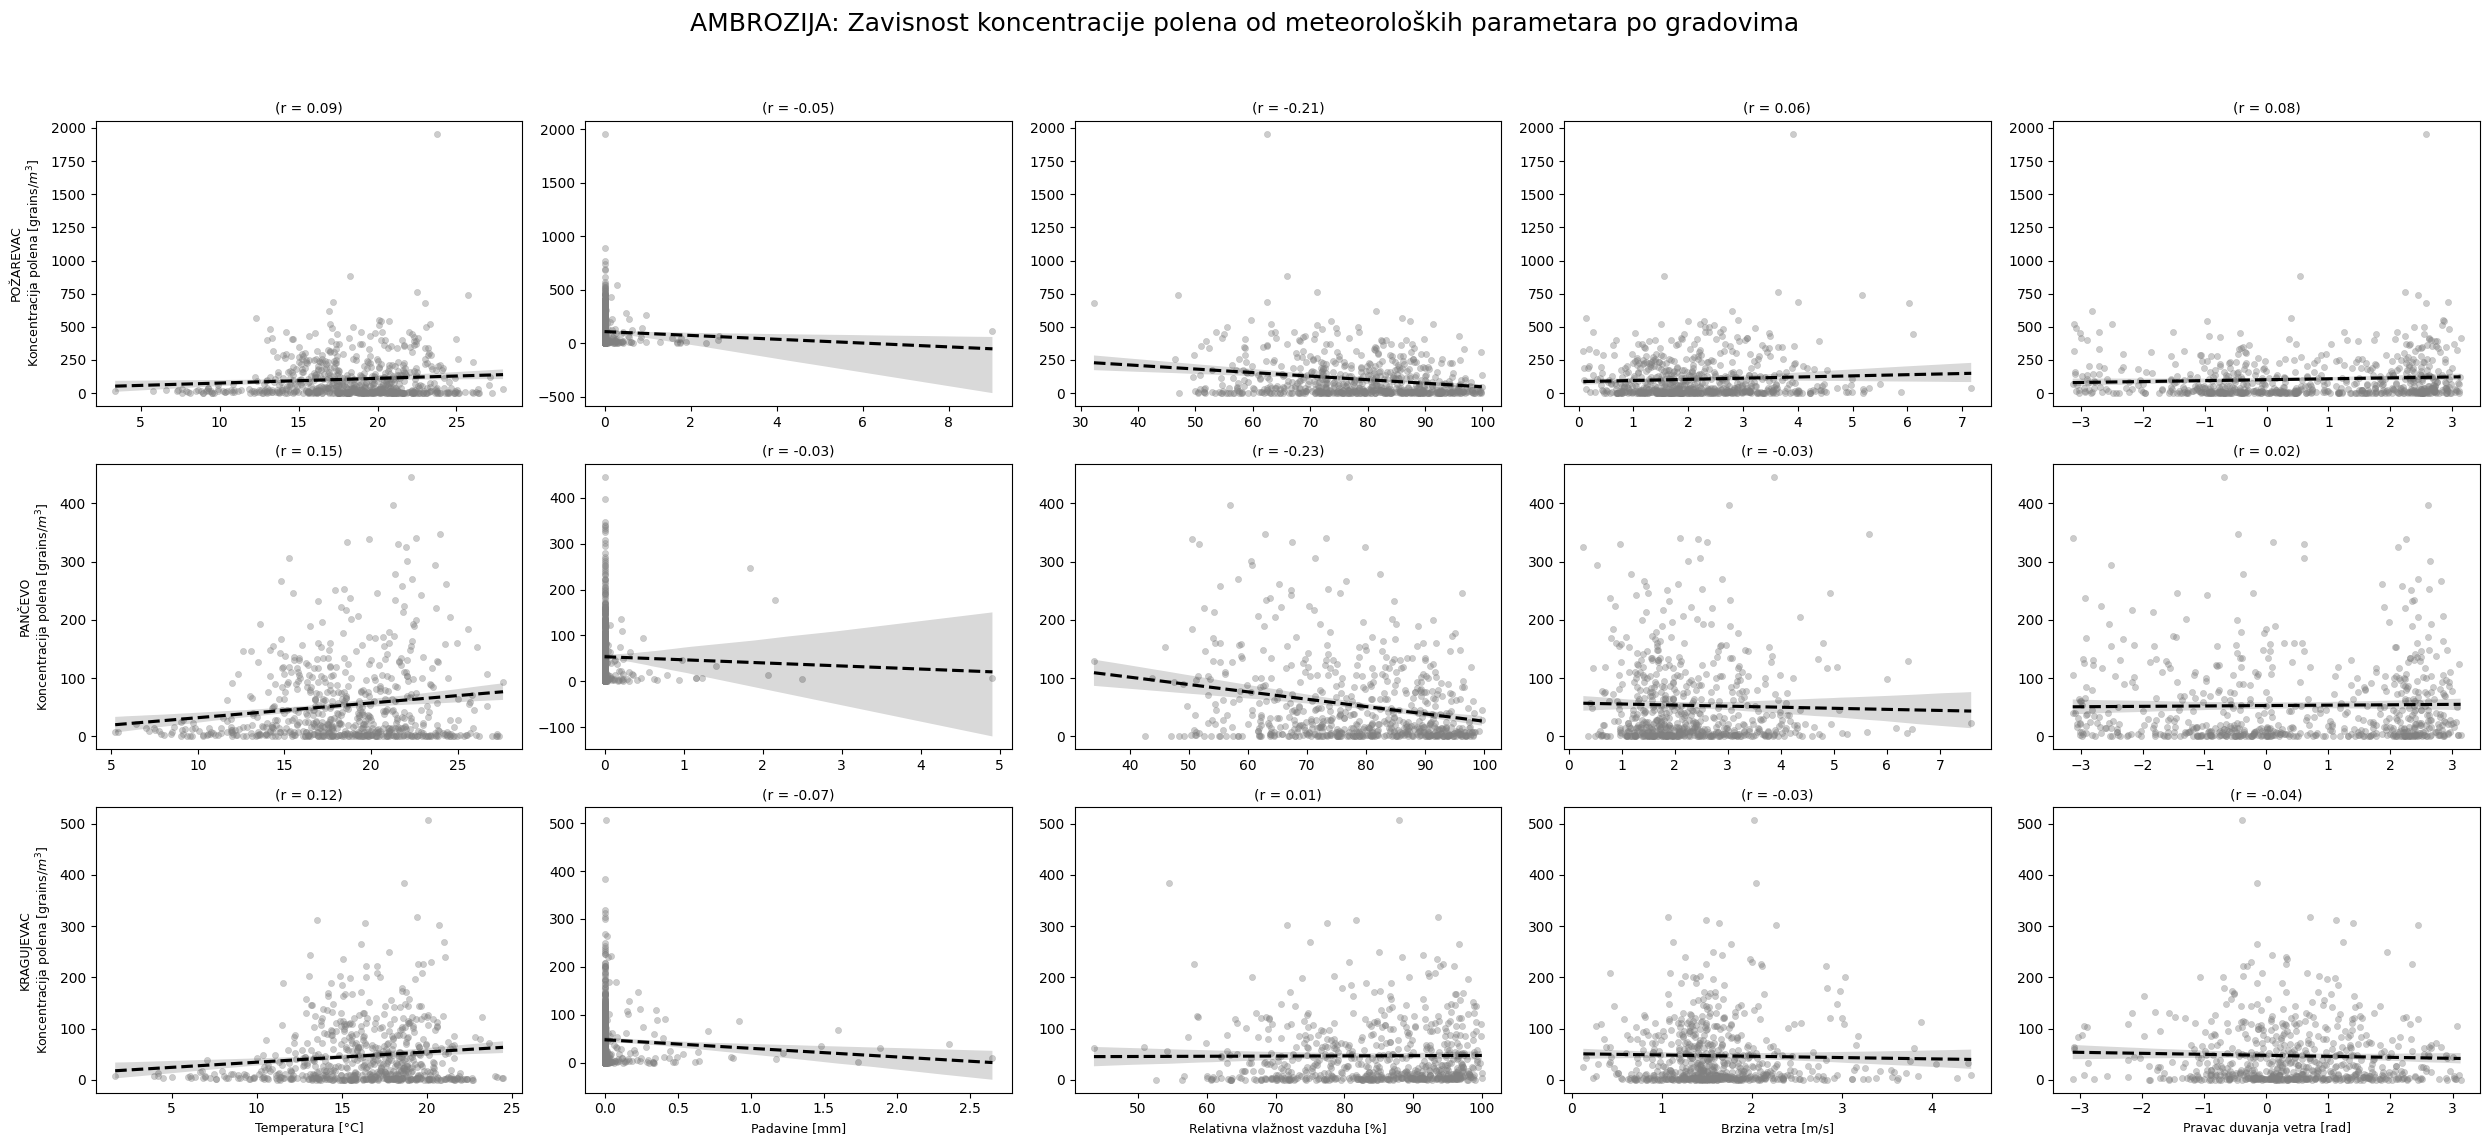

In [15]:
plot_meteo_by_city(meteo, ['POŽAREVAC', 'PANČEVO', 'KRAGUJEVAC'], 'AMBROZIJA', save=True)

In [16]:
# Definiši alergene i meteorološke parametre
allergen_types = ['AMBROZIJA', 'JOVA', 'TRAVE']
meteo_vars = ['temperature', 'precipitation', 'humidity', 'wind', 'wind_direction']

# Kreiraj listu rezultata
results = []

for allergen in allergen_types:
    valid = meteo[(meteo['allergen'] == allergen) & (meteo['location'] == 'KRAGUJEVAC')]
    for param in meteo_vars:
        r, p = pearsonr(valid['value'], valid[param])
        results.append({
            'allergen': allergen,
            'Parametar': param,
            'Pearson_r': round(r, 3),
            'p_value': round(p, 3)
        })

result_df = pd.DataFrame(results)
print(result_df)


     allergen       Parametar  Pearson_r  p_value
0   AMBROZIJA     temperature      0.118    0.002
1   AMBROZIJA   precipitation     -0.066    0.093
2   AMBROZIJA        humidity      0.007    0.855
3   AMBROZIJA            wind     -0.026    0.500
4   AMBROZIJA  wind_direction     -0.037    0.342
5        JOVA     temperature      0.170    0.001
6        JOVA   precipitation     -0.068    0.179
7        JOVA        humidity     -0.180    0.000
8        JOVA            wind      0.076    0.131
9        JOVA  wind_direction      0.109    0.031
10      TRAVE     temperature      0.013    0.638
11      TRAVE   precipitation     -0.058    0.028
12      TRAVE        humidity      0.084    0.002
13      TRAVE            wind      0.010    0.713
14      TRAVE  wind_direction      0.016    0.539


### IMPUTACIJA PODATAKA

In [ ]:
filtered_df['date'] = pd.to_datetime(filtered_df['date'], errors='coerce')
imputed_data = []

# Grupisanje po lokaciji i alergenu
grouped = filtered_df.groupby(['location', 'allergen'], sort=False)

for (loc, allergen), group in grouped:
    group = group.sort_values('date')
    
    # Sve godine u grupi
    years = np.arange(group['date'].dt.year.min(), group['date'].dt.year.max() + 1)
    last_year = years.max()

    # Start i end mesec-dan
    start_md = group['start_date'].iloc[0]
    end_md = group['end_date'].iloc[0]

    last_date = group['date'].max()
    existing_dates = set(group['date'])

    for year in years:
        # Kraj sezone za poslednju godinu uzima last_date, za ostale end_md
        end_date = last_date if year == last_year else pd.to_datetime(f"{year}-{end_md}")
        start_date = pd.to_datetime(f"{year}-{start_md}")

        # Generiši pun raspon datuma za sezonu
        full_range = pd.date_range(start=start_date, end=end_date)

        # Pronađi nedostajuće datume
        missing = [d for d in full_range if d not in existing_dates]

        if missing:
            n = len(missing)
            imputed_data.append(pd.DataFrame({
                'location': [loc] * n,
                'allergen': [allergen] * n,
                'date': missing,
                'value': [np.nan] * n,
                'start_date': [start_md] * n,
                'end_date': [end_md] * n,
                'imputed': [1] * n
            }))

# Kombinovanje imputiranih redova u jedan DataFrame
imputed_df = pd.concat(imputed_data, ignore_index=True) if imputed_data else pd.DataFrame()

# Obeleževanje originalnih podataka
filtered_df['imputed'] = 0

# Kombinovanje originalnih i imputiranih podatke
full_df = pd.concat([filtered_df, imputed_df], ignore_index=True)
full_df.sort_values(by=['location', 'allergen', 'date'], inplace=True)

full_df = full_df.loc[:,['date', 'location', 'allergen', 'value', 'start_date', 'end_date', 'imputed']]
full_df.to_csv('data\\pollen_data_with_imputed_dates.csv', index=False)


## Transformacija podataka

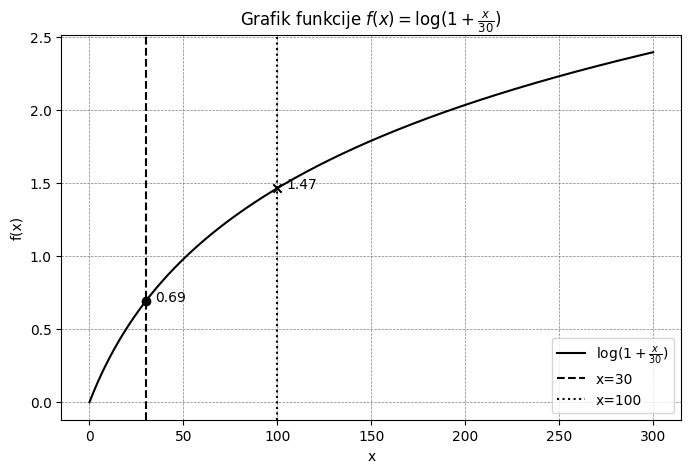

In [18]:
# Priprema x vrednosti
x = np.linspace(0, 300, 1000)

# Transformacija: log1p(x/30)
y = np.log1p(x / 30)

# Izračunavanje y vrednosti za x=30 i x=100
y_30 = np.log1p(30 / 30)
y_100 = np.log1p(100 / 30)

plt.figure(figsize=(8,5))
plt.plot(x, y, color='black', label=r'$\log(1 + \frac{x}{30})$')

plt.axvline(x=30, color='black', linestyle='--', label='x=30')
plt.axvline(x=100, color='black', linestyle=':', label='x=100')

plt.scatter([30], [y_30], color='black', marker='o')
plt.scatter([100], [y_100], color='black', marker='x')
plt.text(30+5, y_30, f'{y_30:.2f}', color='black')
plt.text(100+5, y_100, f'{y_100:.2f}', color='black')

plt.title(r'Grafik funkcije $f(x) = \log(1 + \frac{x}{30})$')
plt.xlabel('x')
plt.ylabel(r'f(x)')
plt.legend()
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
plt.savefig('grafici\\log1p.png', dpi=300)
plt.show()


## TRANSFORMACIJE

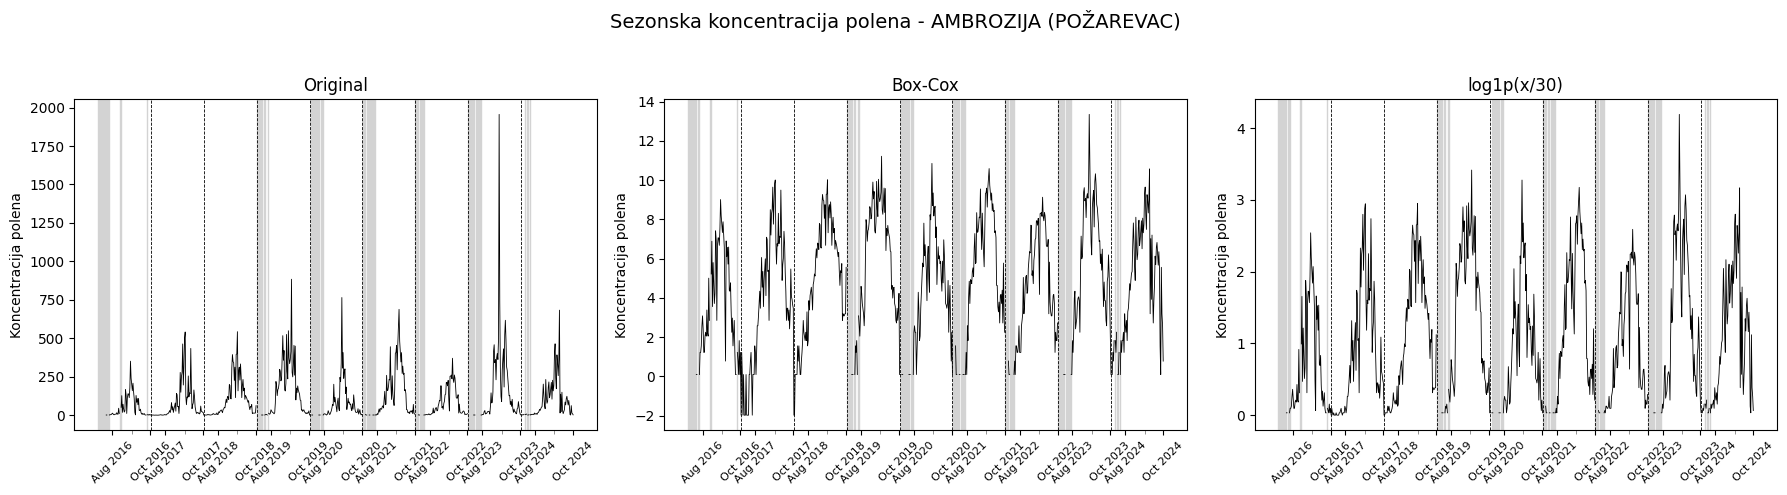

In [19]:
plot_seasonal_concentration_transform(filtered_df[(filtered_df.location == 'POŽAREVAC') & (filtered_df.allergen == 'AMBROZIJA')], save=True)